In [168]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [169]:
from tqdm.auto import tqdm
tqdm.pandas()

In [170]:
from tqdm import tqdm
tqdm.pandas()
import psycopg2

dbparams = {
    'dbname': 'bde',
    'port': 5432,
    'host': 'yuma.hpc.nrel.gov',
    'user': 'bdeops',
    'password': open('/home/pstjohn/Research/bdeops_pass').read().strip(),
    'options': f'-c search_path=bde',
}

with psycopg2.connect(**dbparams) as conn:

    redf = pd.read_sql_query("""
    SELECT * from redoxcompound where status='finished'
    """, conn)

In [171]:
import rdkit.Chem

In [172]:
to_find = ['CC(C(C)C)C1=C(N)C=C([O])S1',
           'CC(C)C2=CCCC3=C2C=C[CH]3',
           '[O]C4=CC(CC)=C(C(O)(C)C)O4',
           'CC(C)(C)C1=C([O])C(C(C)(C)C)=CC=C1',
           '[CH]2C=CC=C2',
           'CC1(CCCC(N1[O])(C)C)C']

In [173]:
def can_smiles(smiles):
    return rdkit.Chem.MolToSmiles(rdkit.Chem.MolFromSmiles(smiles), isomericSmiles=False)

In [174]:
smiles_to_find = pd.Series([can_smiles(smiles) for smiles in to_find])

In [175]:
redf['can_smiles'] = redf.smiles.progress_apply(can_smiles)

100%|██████████| 272686/272686 [00:19<00:00, 13999.75it/s]


In [176]:
is_present = redf[redf['can_smiles'].isin(smiles_to_find)]
is_present.can_smiles.unique()

array(['[CH]1C=CC=C1', 'CC1(C)CCCC(C)(C)N1[O]',
       'CC(C)C1=CCCC2=C1C=C[CH]2', 'CC(C)C(C)c1sc([O])cc1N',
       'CCc1cc([O])oc1C(C)(C)O'], dtype=object)

In [177]:
from rdkit.Chem.Draw import MolsToGridImage

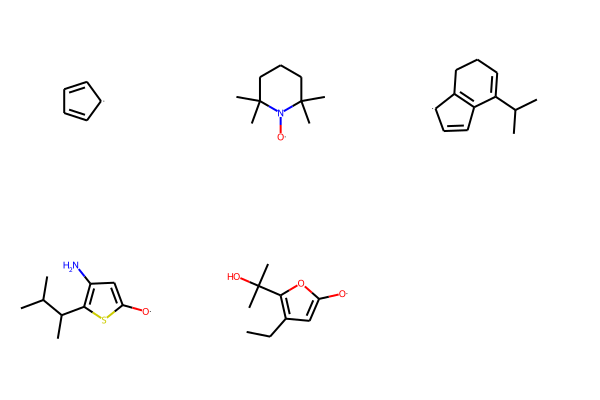

In [178]:
MolsToGridImage([rdkit.Chem.MolFromSmiles(smiles) for smiles in is_present.can_smiles.unique()])

In [179]:
radical_p = is_present[is_present.estate == 'radical'].set_index('smiles')
oxidized_p = is_present[is_present.estate == 'oxidized'].set_index('smiles')
reduced_p = is_present[is_present.estate == 'reduced'].set_index('smiles')

e_electronaffinity = -((reduced_p.freeenergy - radical_p.freeenergy) * 627.509) / 23.061 - 4.281
e_ionizationenery = -((radical_p.freeenergy - oxidized_p.freeenergy) * 627.509) / 23.061 - 4.281

e_ionizationenery.name = 'ionization energy'
e_electronaffinity.name = 'electron affinity'

redox_df = pd.DataFrame(e_ionizationenery).merge(pd.DataFrame(e_electronaffinity),
                                                 left_index=True, right_index=True,
                                                 how='outer')

In [180]:
oxidized_p.freeenergy - reduced_p.freeenergy

smiles
CC(C)C1=CCCC2=C1C=C[CH]2      0.331347
CC(C)[C@H](C)c1sc([O])cc1N    0.336050
CC1(C)CCCC(C)(C)N1[O]         0.295131
CCc1cc([O])oc1C(C)(C)O        0.346211
[CH]1C=CC=C1                  0.377540
Name: freeenergy, dtype: float64

In [181]:
redox_df

,ionization energy,electron affinity
smiles,,
CC(C)C1=CCCC2=C1C=C[CH]2,0.819099,-0.364871
CC(C)[C@H](C)c1sc([O])cc1N,0.949765,-0.367565
CC1(C)CCCC(C)(C)N1[O],0.733167,-1.264407
CCc1cc([O])oc1C(C)(C)O,1.067752,-0.209062
[CH]1C=CC=C1,1.646091,0.065087


In [182]:
background_redox = df = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/redox_data.csv.gz')

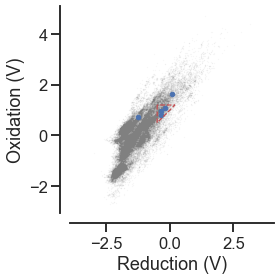

In [183]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal', adjustable='datalim')

# ax.axvspan(-.5, .2, facecolor='.8', edgecolor='none', zorder=0)
# ax.axhspan(.5, 1.2, facecolor='.8', edgecolor='none', zorder=0)

ax.plot(background_redox['electron affinity'], background_redox['ionization energy'], '.', ms=1, alpha=.05, rasterized=True, color='.5')

ax.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none',
                     zorder=5, edgecolor='r', lw=1.25, ls='--', label='symmetric\ntarget'))

plt.plot(redox_df['electron affinity'], redox_df['ionization energy'], '.')
ax.set_xlabel('Reduction (V)')
ax.set_ylabel('Oxidation (V)')
# ax.set_ylim([-2, 4])
# ax.set_xlim([-3, 2])

sns.despine(offset=10)
plt.tight_layout()
plt.savefig('NICS_vs_or.svg')

In [184]:
df = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/20211004_redox_energies.csv.gz')

/home/pstjohn/mambaforge/envs/rlmol/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [199]:
radical = df[df.estate == 'radical'].set_index('smiles')
oxidized = df[df.estate == 'oxidized'].set_index('smiles')
reduced = df[df.estate == 'reduced'].set_index('smiles')

e_electronaffinity = -((reduced.freeenergy - radical.freeenergy) * 627.509) / 23.061 - 4.281
e_ionizationenery = -((radical.freeenergy - oxidized.freeenergy) * 627.509) / 23.061 - 4.281

In [204]:
merged = pd.merge(oxidized, reduced, left_index=True, right_index=True, how='inner', suffixes=['_o', '_r'])
merged['ea'] = e_electronaffinity
merged['ie'] = e_ionizationenery

In [229]:
merged2 = merged.merge(radical, left_index=True, right_index=True, how='inner', suffixes=('', '_rad'))

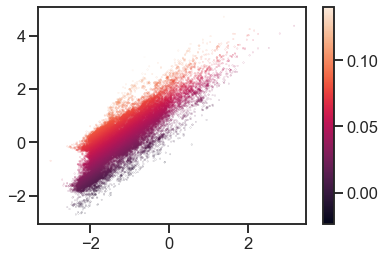

In [265]:
plt.scatter(merged2['ea'], merged2['ie'], marker='.', s=.05, c=(merged2['freeenergy_o'] + merged2['freeenergy_r'] - 2 * merged2['freeenergy']))
plt.colorbar()

In [248]:
merged3 = merged2[merged2['run'] <= 10]

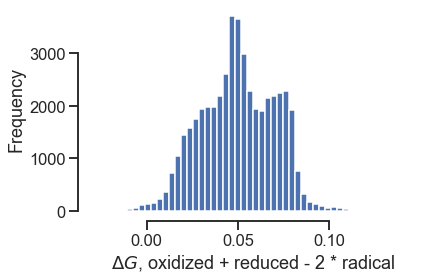

In [249]:
(merged3['freeenergy_o'] + merged3['freeenergy_r'] - 2 * merged3['freeenergy']).plot.hist(bins=50)
plt.xlabel('$\Delta G$, oxidized + reduced - 2 * radical')
# plt.xlim([0.1, .6])
sns.despine(offset=10, trim=True)
plt.tight_layout()
# plt.savefig('energy_diff_hist.svg')

smiles
C[C@@H]1C[CH]COC(=O)C1        0.084537
COC(=O)C[C](C)C#N             0.085610
C=CCCCO[NH]                   0.103506
CC(C)CC1=NCC[N]1              0.087578
[CH2]C                        0.082873
CC(C)N1C[CH]CC1=O             0.084866
C[C@H]1CC[N+]2(C[CH]CC2)C1    0.087547
C[C](C#N)C[C@H](C)C#N         0.083005
O=C1C[CH]C[C@@H]2C[C@H]12     0.080252
C/C([CH]CC(=O)O)=N/O          0.080316
dtype: float64

In [259]:
g_diff = merged3['freeenergy_o'] + merged3['freeenergy_r'] - 2 * merged3['freeenergy']
head = g_diff[g_diff > g_diff.dropna().quantile(.95)].sample(10)
tail = g_diff[g_diff < g_diff.dropna().quantile(.05)].sample(10)

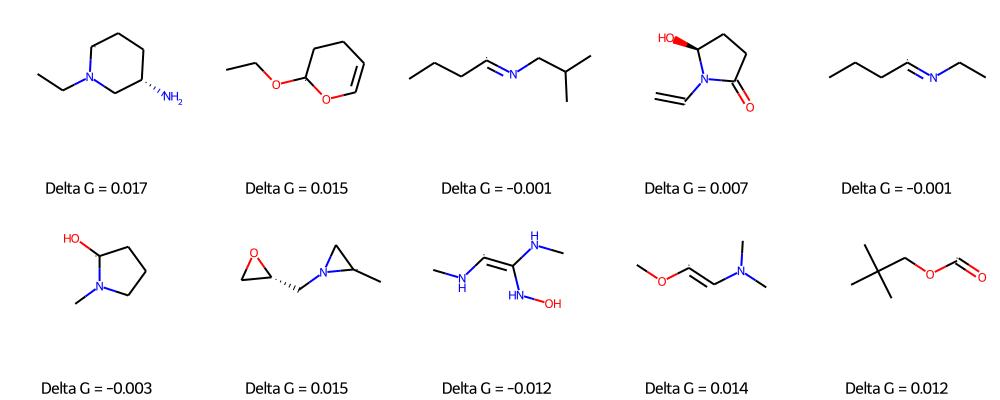

In [260]:
MolsToGridImage([rdkit.Chem.MolFromSmiles(smiles) for smiles in tail.index],
                legends=[f'Delta G = {val:.3f}' for val in tail], molsPerRow=5)

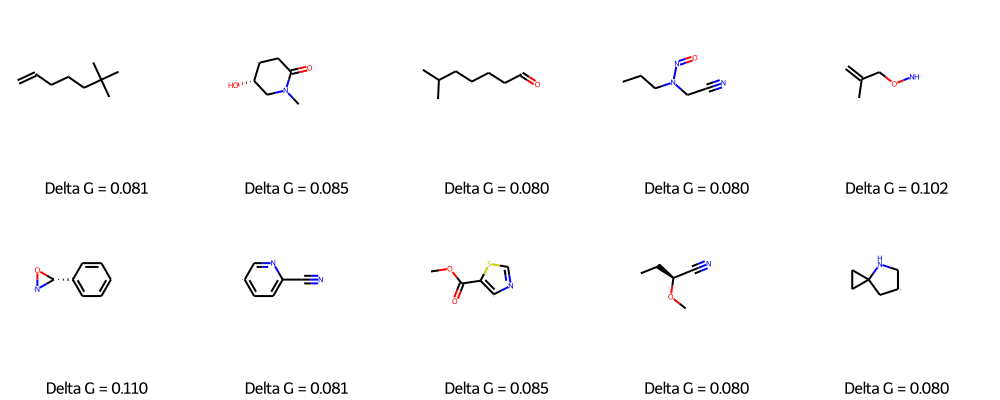

In [261]:
MolsToGridImage([rdkit.Chem.MolFromSmiles(smiles) for smiles in head.index],
                legends=[f'Delta G = {val:.3f}' for val in head], molsPerRow=5)

In [75]:
oxidized_p.freeenergy - reduced_p.freeenergy

smiles
CC(C)C1=CCCC2=C1C=C[CH]2      0.331347
CC(C)[C@H](C)c1sc([O])cc1N    0.336050
CC1(C)CCCC(C)(C)N1[O]         0.295131
CCc1cc([O])oc1C(C)(C)O        0.346211
[CH]1C=CC=C1                  0.377540
Name: freeenergy, dtype: float64